In [27]:
from agent_library import library
from agent_class import CriticalEvaluatorAgent, DoctorAgent
from tools import PubMedTool
import pandas as pd
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from agent_library import library
from tools import PubMedTool
pubmed_tool = PubMedTool()


import os

os.environ["OPENAI_API_KEY"] = "place_holder"
llm = ChatOpenAI(model_name='gpt-4')


In [29]:
evaluator_agent = CriticalEvaluatorAgent(profile = library['Critical Evaluator']['profile'], pubmed_tool = pubmed_tool)
doctor_agent = DoctorAgent(profile = library['Doctor']['profile'])

/Users/kiki/Desktop/LLM_predict/agent_class.py:37: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  self.chain = LLMChain(llm = self.llm, prompt = self.prompt_template)


In [38]:
df2 = pd.read_csv('deduplicated_1yr_data.csv')

results = []
for _, row in df2.iterrows():

    label_data = row['CDR_score']
    subjective = row['主訴(S)']
    assessment = row['診斷(A)']
    plan = row['計畫(P)']
    
    prediction = doctor_agent.predict(subjective, assessment, plan)

     
    # Evaluator evaluates the prediction
    feedback = evaluator_agent.evaluate(prediction, subjective, assessment, plan)
    
    # Doctor revises the prediction based on feedback
    revised_prediction = doctor_agent.revise(feedback, subjective, assessment, plan)
    
    results.append({
            "Subjective": subjective,
            "Assessment": assessment,
            "Plan": plan,
            "Prediction": revised_prediction
        })

In [39]:
results

[{'Subjective': 'on wheelchair; come with son;',
  'Assessment': 'mmse 15/24; cdr 01;',
  'Plan': 'opd follow-up',
  'Prediction': "The patient is diagnosed with Alzheimer's disease. Based on the available data and patient assessment, the Clinical Dementia Rating (CDR) level is 1.0, indicating mild dementia. \n\nTERMINATE"},
 {'Subjective': 'ome with wife;note episode of depression and hypomanic state;',
  'Assessment': 'note hypomanic state for now;early awakening and speep for only 4 hrs a day; 107/09/28 mood,elated; hyperactive, hypertalkative; ealy awakening 110/3/23 informs: memory impairment;cdr 0.5;',
  'Plan': 'opd follow-up',
  'Prediction': "The patient is confirmed to have Alzheimer's disease. The Clinical Dementia Rating (CDR) level is 0.5. TERMINATE."},
 {'Subjective': 'come with son and a an attendant; on wheelchair; stay at a nursing home;',
  'Assessment': 'age, 80 some x, point son, v; spending money a lot;jomac, relatively intact, fair;mildly impaired memory; mmse 8/2

In [42]:
import re
import pandas as pd

# Functions to extract CDR levels
def extract_predicted_cdr(prediction_text):
    pattern = r'CDR.*?(\d+(\.\d+)?)'
    match = re.search(pattern, prediction_text, re.IGNORECASE)
    if match:
        return float(match.group(1))
    else:
        return None

def extract_actual_cdr(assessment_text):
    pattern = r'cdr[:= ]+(\d+(\.\d+)?)'
    match = re.search(pattern, assessment_text, re.IGNORECASE)
    if match:
        return float(match.group(1))
    else:
        # Try another pattern: e.g., 'cdr(\d+(\.\d+)?)' without spaces
        pattern_alt = r'cdr(\d+(\.\d+)?)'
        match_alt = re.search(pattern_alt, assessment_text, re.IGNORECASE)
        if match_alt:
            return float(match_alt.group(1))
        else:
            return None

# Initialize counters
correct_predictions = 0
total_cases = 0

# Lists to store comparison data
comparison_data = []
predicted_cdrs = []

for result in results:
    prediction_text = result['Prediction']
    
    # Extract predicted and actual CDR levels
    predicted_cdr = extract_predicted_cdr(prediction_text)
    predicted_cdrs.append(predicted_cdr)

    print(predicted_cdr)
df2['Predicted_CDR'] = predicted_cdrs


# Calculate accuracy
total_cases = 0
correct_predictions = 0

for _, row in df2.iterrows():
    actual_cdr = row['CDR_score']  # Actual CDR label
    predicted_cdr = row['Predicted_CDR']  # Predicted CDR label

    # Count valid cases and correct predictions
    if pd.notnull(predicted_cdr) and pd.notnull(actual_cdr):
        total_cases += 1
        if actual_cdr == predicted_cdr:
            correct_predictions += 1

# Compute accuracy
accuracy = (correct_predictions / total_cases) * 100 if total_cases > 0 else 0

# Display the results
print(f'Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_cases})')

1.0
0.5
2.0
3.0
1.0
1.0
1.0
1.0
2.0
0.5
Accuracy: 80.00% (8/10)


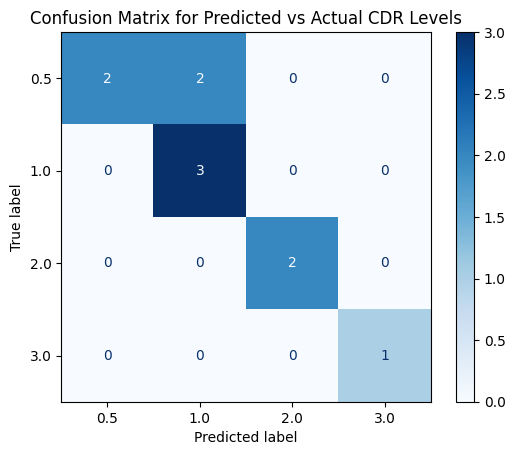

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define valid labels
valid_labels = [0.5, 1.0, 2.0, 3.0]
label_mapping = {value: i for i, value in enumerate(valid_labels)}  # Map to integers

# Map floating-point labels to integers
actual_cdrs_mapped = df2['CDR_score'].map(label_mapping).dropna().astype(int)
predicted_cdrs_mapped = df2['Predicted_CDR'].map(label_mapping).dropna().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(actual_cdrs_mapped, predicted_cdrs_mapped, labels=list(label_mapping.values()))

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Predicted vs Actual CDR Levels')
plt.show()

In [48]:
from sklearn.metrics import f1_score, classification_report

# Define valid labels
valid_labels = [0.5, 1.0, 2.0, 3.0]
label_mapping = {value: i for i, value in enumerate(valid_labels)}  # Map to integers

# Map floating-point labels to integers
actual_cdrs_mapped = df2['CDR_score'].map(label_mapping).dropna().astype(int)
predicted_cdrs_mapped = df2['Predicted_CDR'].map(label_mapping).dropna().astype(int)

# Calculate F1-score
f1 = f1_score(actual_cdrs_mapped, predicted_cdrs_mapped, average='weighted')  # Use 'micro', 'macro', or 'weighted'
print(f"F1-Score (Weighted): {f1:.2f}")

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(actual_cdrs_mapped, predicted_cdrs_mapped, target_names=[str(l) for l in valid_labels]))

F1-Score (Weighted): 0.79

Classification Report:

              precision    recall  f1-score   support

         0.5       1.00      0.50      0.67         4
         1.0       0.60      1.00      0.75         3
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         1

    accuracy                           0.80        10
   macro avg       0.90      0.88      0.85        10
weighted avg       0.88      0.80      0.79        10

